# OpenAI 의 Gym
(http://gym.openai.com/docs/)

Gym 은 강화학습을 개발하기 위한 툴킷 (http://gym.openai.com/)

설치는 pip으로 가능

```
$ pip install gym
```

추가로 아래 패키지도 설치

```
$ pip install PILLOW
$ pip install tensorflow
$ pip install imageio
```

(설치 환경 특이 사항)
* gym 에서는 enviroment의 render메쏘드로 에이전트 학습을 위한 환경을 사람이 볼 수 있게 해줌(numpy array로도 리턴이 가능)
* 그런데, 이 render를 쓰기 위해서는 x window 같은 화면 출력 환경이 있어야 함
* 아니라면 render 없이 사용할 것

In [1]:
# 패키지 불러오기
import gym
import PIL.Image
import matplotlib.pyplot as plt
from IPython import display
import time
import imageio
import glob

%matplotlib inline

## CartPole-v0

막대가 카트의 조인트 하나에 매달려 있다. 카트는 마찰이 없는 트랙 위에서만 움직인다. 이 시스템에서는 **카트에 +1 또는 -1 만 줄 수 있다(좌우로 움직이게 하는 값)**. **목표**는 **막대가 최대한 오랜 시간 동안 넘어지지 않게** 하는 것이다. 또는 카트가 화면 밖으로 나가면 안된다. **막대가 서 있는 타임 스텝 한 번 당 +1씩 보상**이 주어진다. 만약 **막대가 수직에서 15도 이상 넘어가**거나 **카트가 중심으로부터 2.4 유닛 이상 벗어나**면 **에피소드가 종료**한다.

자세한 사항은 위키를 참고하자. https://github.com/openai/gym/wiki/CartPole-v0

## Environments

* 그냥 바로 예제 하나를 실행해보면 쉽게 다가갈 수 있음
* <a style='color:red;background-color:pink'>CartPole-v0</a> 이라는 예제를 돌려보자.

In [2]:
# env 를 기록해두기 위한 리스트
env_screen = []

# 환경 생성
env = gym.make('CartPole-v0')

# 초기값으로 리셋
env.reset()

# 그냥 덮어두고 1000스텝을 어떻게든 돌리기
for _ in range(1000):
    # 화면에 환경 매 순간을 나타냄
    env_screen.append(env.render(mode='rgb_array'))
    # step에 env에서 에이전트가 취할 수 있는 action을 랜덤하게 넣어보기
    env.step(env.action_space.sample())
    
env.close()

C:\Users\woong\miniconda3\envs\rl\lib\site-packages\gym\logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [11]:
def save_image(screenshot, time_step):
    plt.figure(figsize=(4, 4))
    plt.imshow(screenshot[time_step])
    plt.axis('off')
    plt.savefig(f'./images/cartpole-{time_step:05d}')
    plt.close()

In [12]:
for t in range(len(env_screen)):
    save_image(env_screen, t)

In [13]:
def generate_gif(file_gif, s, e):
    
    with imageio.get_writer(file_gif, mode='I') as writer:
        filenames = glob.glob('./images/cartpole-*.png')
        filenames = sorted(filenames)
        last = -1
        for i, filename in enumerate(filenames):
            frame = 5*(i**.5)
            if round(frame) > round(last):
                last = frame
            else:
                continue
            image = imageio.imread(filename)
            writer.append_data(image)

컴퓨터가 좋으면 env.render()메쏘드 실행시켰을 때 쏜살같이 환경이 켜졌다 꺼진다. GIF 파일로 만들어서 느리게 무슨 일이 생기나 보자.

그림엔 안나오지만 카트폴이 실은 라인 위에서 좌우로만 움직이며 막대가 서있을 수 있도록 중심을 잘 잡아야 한다.

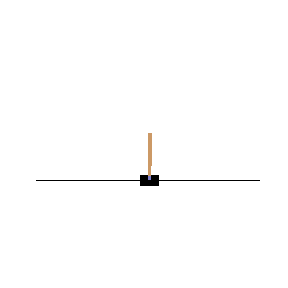

In [14]:
file_gif = './gif/cartpole.gif'
generate_gif(file_gif, 0, len(env_screen))
display.Image(filename=file_gif)

## Observations
<a style='color:red;background-color:pink'>step</a> 메쏘드는 아래 네 가지 값을 리턴 함
* <a style='color:red;background-color:pink'>observation</a> **(object)**: 환경에서 관측할 수 있는 것. 카메라로 찍은 픽셀 데이터나, 로봇의 관절 각도나 속도 또는 보드 게임이면 보드의 상태
* <a style='color:red;background-color:pink'>reward</a> **(float)**: 이전 액션으로부터 얻은 보상. 환경마다 스케일이 다름. 최종 목표는 리워드 총합을 늘리는 것
* <a style='color:red;background-color:pink'>done</a> **(boolean)**: 환경을 <a style='color:red;background-color:pink'>reset</a> 할지 말지. <a style='color:red;background-color:pink'>done</a> 값이 <a style='color:red;background-color:pink'>True</a> 가 되면 에피소드가 종료 됨. 게임에서 라이프를 다 잃어버리는 경우를 생각해보면 됨
* <a style='color:red;background-color:pink'>info</a> **(dict)**: 환경의 raw probability 정보 같은게 담겨 있음. 디버깅에 쓸 수 있지만 에이전트 평가에 쓰면 안됨

에이전트가 <a style='color:red;background-color:pink'>action</a>을 취하고, 환경에서 <a style='color:red;background-color:pink'>observation</a>과 <a style='color:red;background-color:pink'>reward</a>를 리턴 받는 것이 구현 되어 있음
![image1](http://gym.openai.com/assets/docs/aeloop-138c89d44114492fd02822303e6b4b07213010bb14ca5856d2d49d6b62d88e53.svg)

더욱 올바른 gym environment 사용법은 아래와 같음

In [15]:
# 환경 생성
env = gym.make('CartPole-v0')

# 총 20 에피소드만 돌리기
for i_episode in range(20):
    # 초기화 했을 때도 상태를 관측할 수 있음
    observation = env.reset()
    
    # 에피소드마다 최대 100번의 타임스텝만 진행
    for t in range(100):
        # 화면에 그리기
#         env.render()

        # 환경 관측 결과 확인
        print(observation)
        
        # 액션 선택지 중에서 랜덤하게 고르기
        action = env.action_space.sample()
        
        # 스텝 메쏘드로 정말 액션 취하기
        observation, reward, done, info = env.step(action)
        
        # 에피소드 끝나면 타임 스텝 더이상 진행 하지 않음
        if done:
            print(f"Episode finished after {t+1} timesptes.")
            break
            
# 환경 종료
env.close()

[-0.03840609 -0.04638655 -0.03378102  0.01522466]
[-0.03933383  0.14920317 -0.03347653 -0.28792227]
[-0.03634976 -0.04542579 -0.03923497 -0.00598266]
[-0.03725828  0.15023624 -0.03935462 -0.31078196]
[-0.03425355 -0.04430356 -0.04557026 -0.03076548]
[-0.03513962 -0.23874339 -0.04618557  0.24719846]
[-0.03991449 -0.43317634 -0.0412416   0.52496315]
[-0.04857802 -0.23749902 -0.03074234  0.21957516]
[-0.053328   -0.43216835 -0.02635084  0.50240435]
[-0.06197137 -0.23668508 -0.01630275  0.20153499]
[-0.06670507 -0.04133381 -0.01227205 -0.09624577]
[-0.06753174 -0.23627774 -0.01419697  0.19254022]
[-0.0722573  -0.43119375 -0.01034616  0.480711  ]
[-8.08811732e-02 -6.26168141e-01 -7.31941920e-04  7.70115215e-01]
[-0.09340454 -0.43103612  0.01467036  0.47720208]
[-0.10202526 -0.6263621   0.0242144   0.77447245]
[-0.1145525  -0.43158147  0.03970385  0.4895055 ]
[-0.12318413 -0.23704148  0.04949396  0.20959535]
[-0.12792496 -0.04266088  0.05368587 -0.06707321]
[-0.12877818 -0.23850979  0.052344

## Spaces
위에서 덮어두고 액션을 취했는데, 이 환경에서 액션이 정확히 뭐가 있냐? 모든 환경은 <a style='color:red;background-color:pink'>action_space</a> 와 <a style='color:red;background-color:pink'>observation_space</a>가 있다. 이 속성들은 <a style='color:red;background-color:pink'>space</a>형이라고 한다. 이 공간 안의 액션과 관측이 유효한 값이다.

In [16]:
env = gym.make('CartPole-v0')
print(env.action_space)
print(env.observation_space)

Discrete(2)
Box(4,)


In [18]:
print(env.observation_space.high)
print(env.observation_space.low)

[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]


<a style='color:red;background-color:pink'>Box</a> 나 <a style='color:red;background-color:pink'>Discrete</a> 는 gym 에서 공통적으로 사용하는 <a style='color:red;background-color:pink'>Space</a>다. 이 <a style='color:red;background-color:pink'>Space</a>에서 랜덤하게 값을 샘플링할 수 있다.

In [32]:
from gym import spaces

# 원소 {0, 1, ..., 7} 인 집합
space = spaces.Discrete(8)
x = space.sample()
assert space.contains(x)
assert space.n == 8

for _ in range(10):
    print(space.sample())

5
6
5
7
6
2
4
4
1
1


In [33]:
s = spaces.Box(-1, 1, shape=(1,))

for _ in range(10):
    print(s.sample())

[-0.51022106]
[-0.5670855]
[-0.6679044]
[0.8455132]
[-0.41184667]
[-0.09381151]
[-0.01208433]
[0.5563432]
[0.68846995]
[-0.7218546]


## 더욱 다양한 환경
http://gym.openai.com/envs/#classic_control 를 참고하자.